# **Lane Detection**

### **Importing the libraries**

In [0]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

### **Read an image**

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


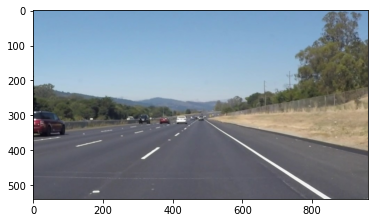

In [79]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### **Color Selection**

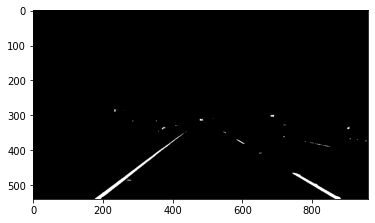

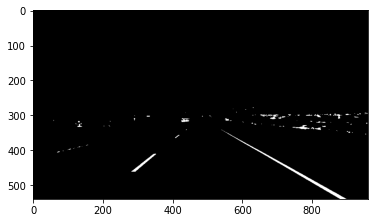

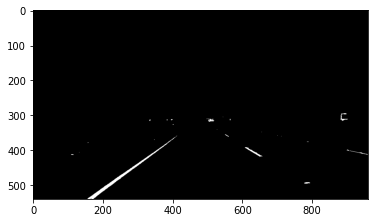

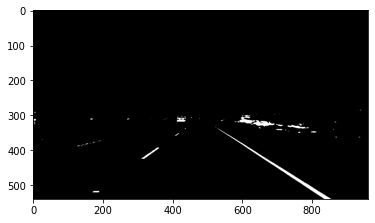

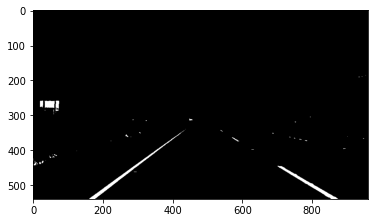

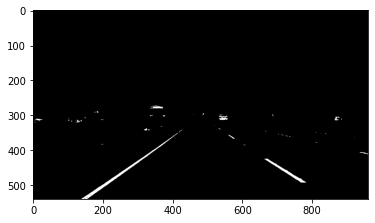

In [80]:
images = os.listdir("test_images/") 
def color_select(img):        
    rgb_thresholds = np.array([210,110,70]) 
    white = np.array([255,255,255])
    return cv2.inRange(img, rgb_thresholds, white) 

for image in images:
    pic = mpimg.imread("test_images/"+image)  
    img = color_select(pic)
    plt.figure()
    plt.imshow(img, cmap='gray')

### **Region Marking**

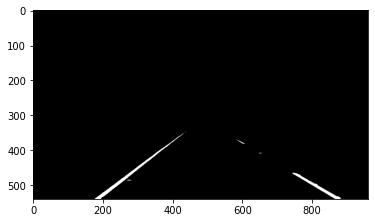

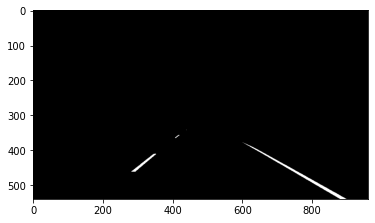

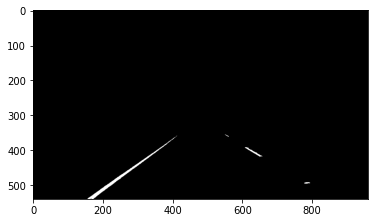

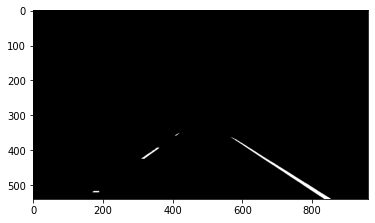

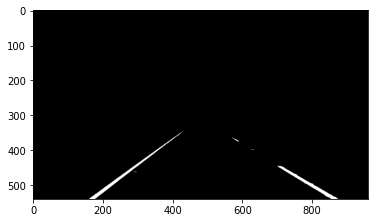

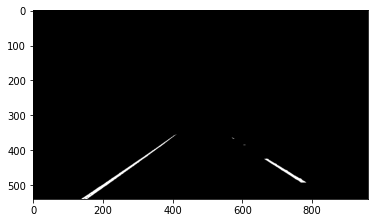

In [81]:
def region_of_interest(img):
    y_shape = img.shape[0]
    x_shape = img.shape[1]
    vertices = np.array([[x_shape/2, y_shape*0.6], [x_shape/2, y_shape*0.6],
              [x_shape, y_shape*1], [0, y_shape*1]], dtype=np.int32)
  #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
for image in images:
    pic = mpimg.imread("test_images/"+image)  
    img = color_select(pic)
    img=region_of_interest(img)
    plt.figure()
    plt.imshow(img, cmap='gray')


### **Edge detection through canny(OpenCV)**

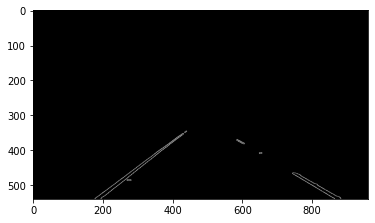

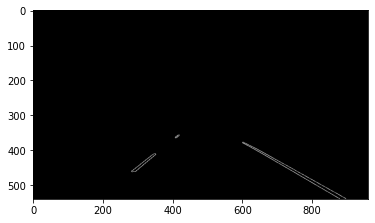

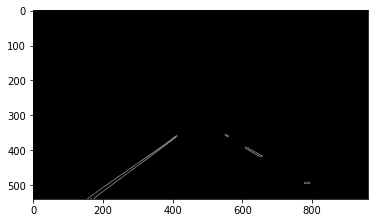

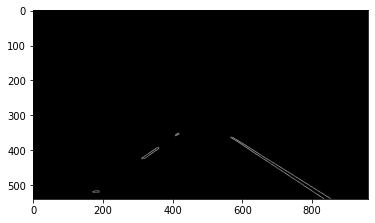

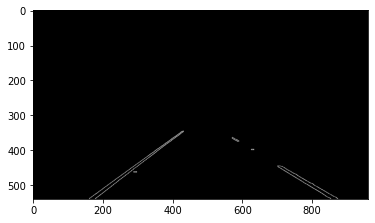

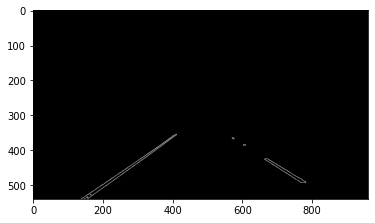

In [82]:
#function to change the color space
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#function to detect edges
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#function for image smoothing or blurring
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

for image in images:
    pic = mpimg.imread("test_images/"+image)  
    img = color_select(pic)
    img=region_of_interest(img)
    if(len(img.shape)>2):
      img=grayscale(img)
    img=gaussian_blur(img,5)
    img=canny(img,50,150)
    plt.figure()
    plt.imshow(img, cmap='gray')

### **Hough Transform**

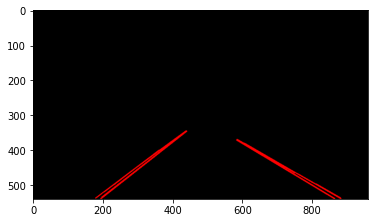

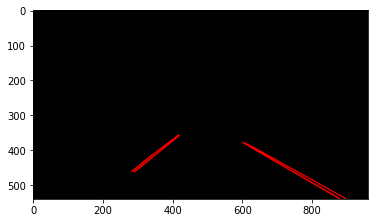

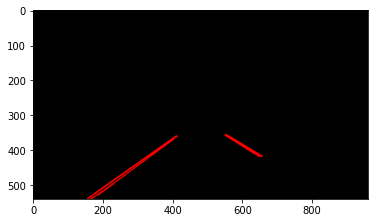

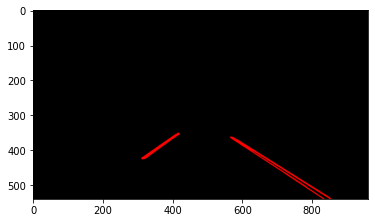

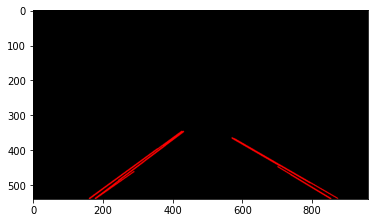

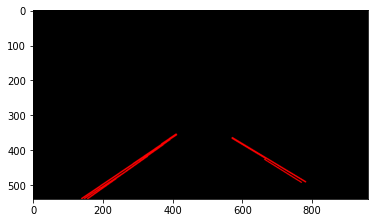

In [83]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


#introducing Hough transform
for image in images:
    pic = mpimg.imread("test_images/"+image)  
    img = color_select(pic)
    img=region_of_interest(img)
    if(len(img.shape)>2):
      img=grayscale(img)
    img=gaussian_blur(img,5)
    img=canny(img,50,150)
    img = hough_lines(img, rho=1, theta=np.pi/180, threshold=10, min_line_len=40, max_line_gap=100)
    plt.figure()
    plt.imshow(img, cmap='gray')


### **Main Function**

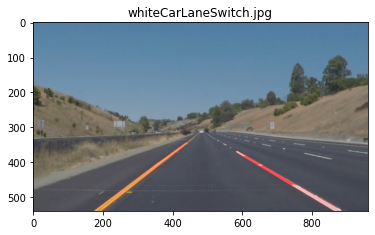

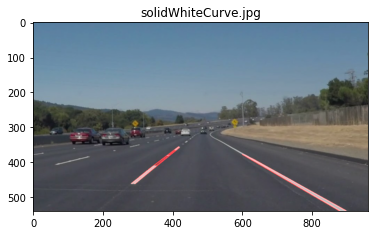

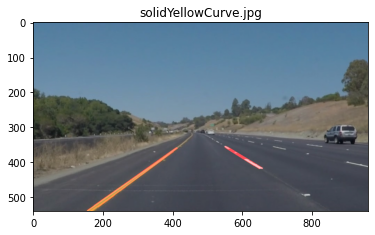

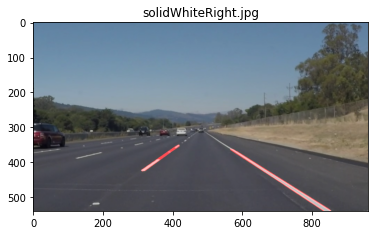

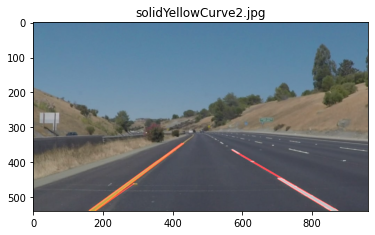

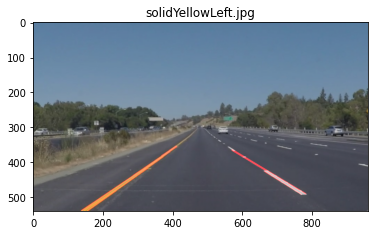

In [84]:
def weighted_img(img, initial_img, a=0.8, b=1., y=0.):
    return cv2.addWeighted(initial_img, a, img, b, y)

def pipeline_hough(image):
    
    img = np.copy(image)
    img = color_select(img)
    img = region_of_interest(img) #calling the ROI function 
    if(len(img.shape)>2):
      img=grayscale(img)
    img=gaussian_blur(img,5)
    img=canny(img,50,150)
    img = hough_lines(img, rho=1, theta=np.pi/180, threshold=10, min_line_len=40, max_line_gap=100)
    img = weighted_img(img, image) 
    return img
    
for image in images:  
    img = mpimg.imread("test_images/"+image);
    img = pipeline_hough(img)
    plt.figure()
    plt.title(image)
    plt.imshow(img, cmap='gray') 
    split = image.split('.') 
    imgName = split[0] + '_lanes.jpg' 
    mpimg.imsave(os.path.join('test_images', imgName), img) 

In [85]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result =pipeline_hough(image)
    return result

white_output = 'test_videos_output/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4



100%|█████████▉| 221/222 [00:09<00:00, 22.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 3.15 s, sys: 352 ms, total: 3.5 s
Wall time: 11.5 s
